In [219]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from h3 import h3

### First of all, lets see the head of the two dataframe and use the info() method to see what variables we have:

In [220]:
df_offer = pd.read_csv('../artifacts/data/data_offers.csv')
df_order = pd.read_csv('../artifacts/data/data_orders.csv')


In [221]:
df_order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [222]:
df_offer.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [223]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [224]:
df_offer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [225]:
df_order['is_driver_assigned_key'].value_counts()

0    7902
1    2814
Name: is_driver_assigned_key, dtype: int64

In [226]:
df_order['is_driver_assigned_key'] = df_order['is_driver_assigned_key'].map({1: 'yes', 0: 'no'})
df_order['order_status_key'] = df_order['order_status_key'].map({4: 'by_client', 9: 'by_system'})


### Task 1: Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [227]:
df_order['is_driver_assigned_key'].value_counts()

no     7902
yes    2814
Name: is_driver_assigned_key, dtype: int64

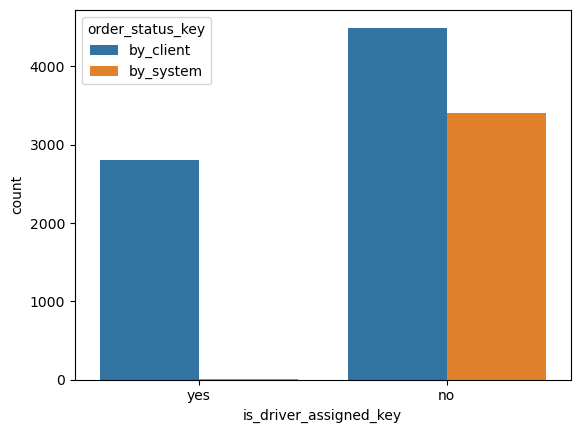

In [228]:
plot=sns.countplot( x=df_order['is_driver_assigned_key'], hue=df_order['order_status_key'])

In [229]:
df_order[(df_order['is_driver_assigned_key']=='yes') & (df_order['order_status_key']=='by_system')].count()

order_datetime                   3
origin_longitude                 3
origin_latitude                  3
m_order_eta                      3
order_gk                         3
order_status_key                 3
is_driver_assigned_key           3
cancellations_time_in_seconds    0
dtype: int64

### Task 2: Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [230]:
df_order['order_datetime']=pd.to_datetime(df_order['order_datetime'])

In [231]:
grouped = df_order.groupby([df_order.order_datetime.dt.hour,'is_driver_assigned_key','order_status_key'])['order_gk'].count()

In [232]:
grouped

order_datetime  is_driver_assigned_key  order_status_key
0               no                      by_client           298
                                        by_system           263
                yes                     by_client           120
                                        by_system             2
1               no                      by_client           219
                                                           ... 
22              no                      by_system           241
                yes                     by_client           149
23              no                      by_client           378
                                        by_system           302
                yes                     by_client           156
Name: order_gk, Length: 74, dtype: int64

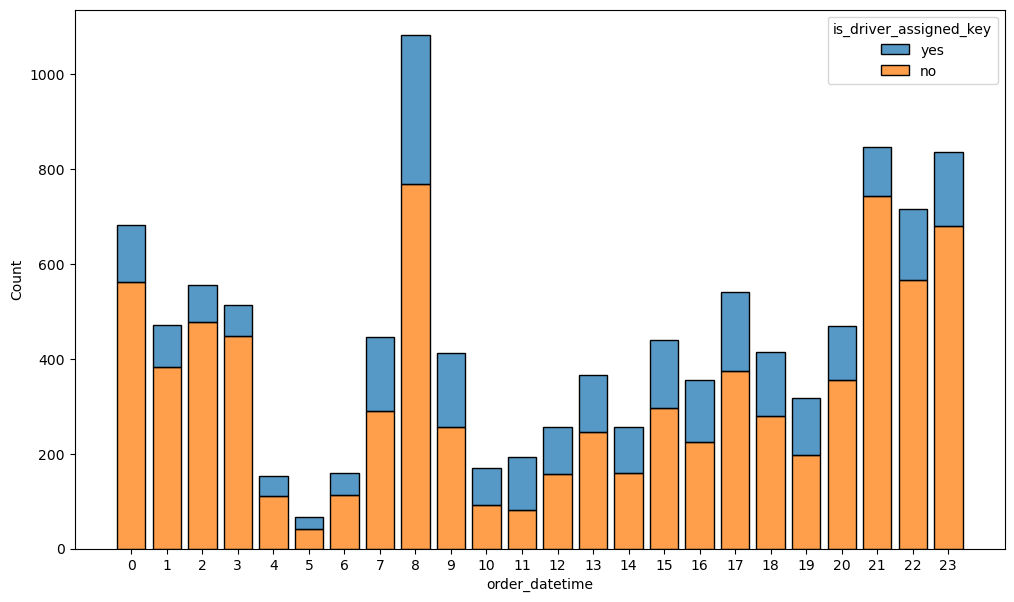

In [233]:
plt.figure(figsize=(12,7))

graph= sns.histplot(x=df_order.order_datetime.dt.hour,hue=df_order['is_driver_assigned_key'],
                    discrete=True, multiple="stack",shrink=0.8)

graph.set_xticks(range(0,24))

plt.show()

### Task 3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

Let's look at a statistical description of the column 'cancellations_time_in_seconds' and then do a box plot to see possible outliers:

In [234]:
df_order['cancellations_time_in_seconds'].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

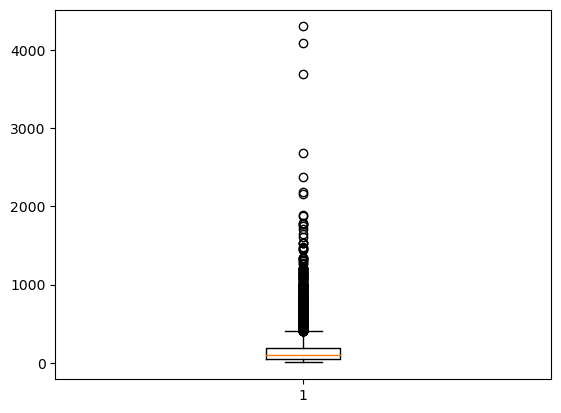

In [235]:
plt.boxplot(df_order['cancellations_time_in_seconds'].dropna())
plt.show()

Let's filter our data to remove that values which exceed 325 seconds, to avoid that outliers

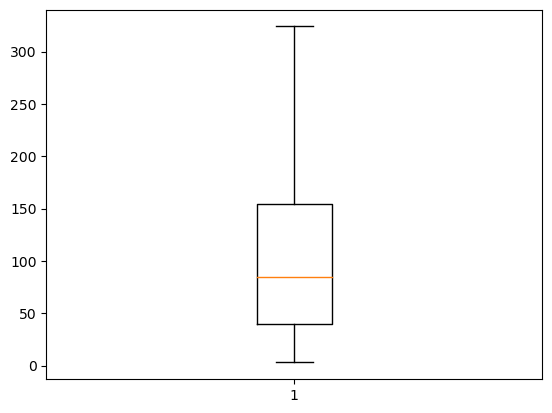

In [236]:
df_order_out=df_order[df_order['cancellations_time_in_seconds']<325]
plt.boxplot(df_order_out['cancellations_time_in_seconds'].dropna())
plt.show()

In [237]:

hours = df_order_out.groupby([df_order_out.order_datetime.dt.hour,'is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index()

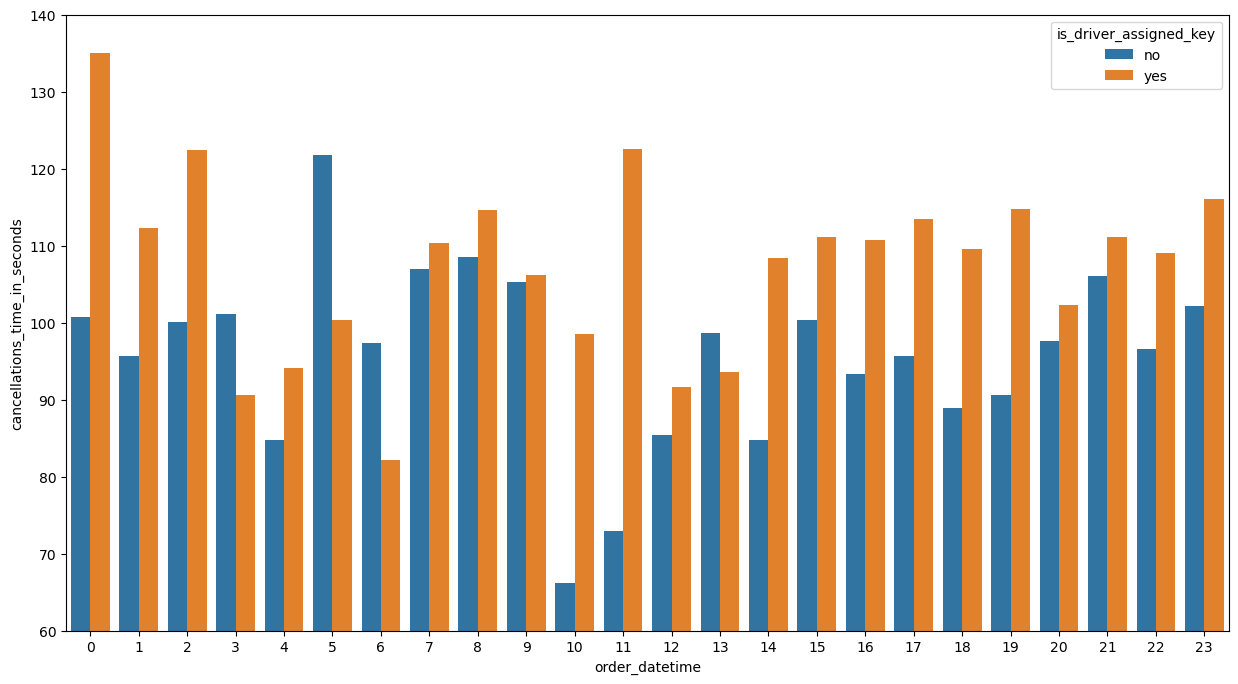

In [238]:
binsa=list(range(0,24))

plt.figure(figsize=(15,8))
sns.barplot(x=hours['order_datetime'],y=hours['cancellations_time_in_seconds'], hue=hours['is_driver_assigned_key'])
plt.ylim(60, 140)
graph.set_xticks(range(0,24))
plt.show()

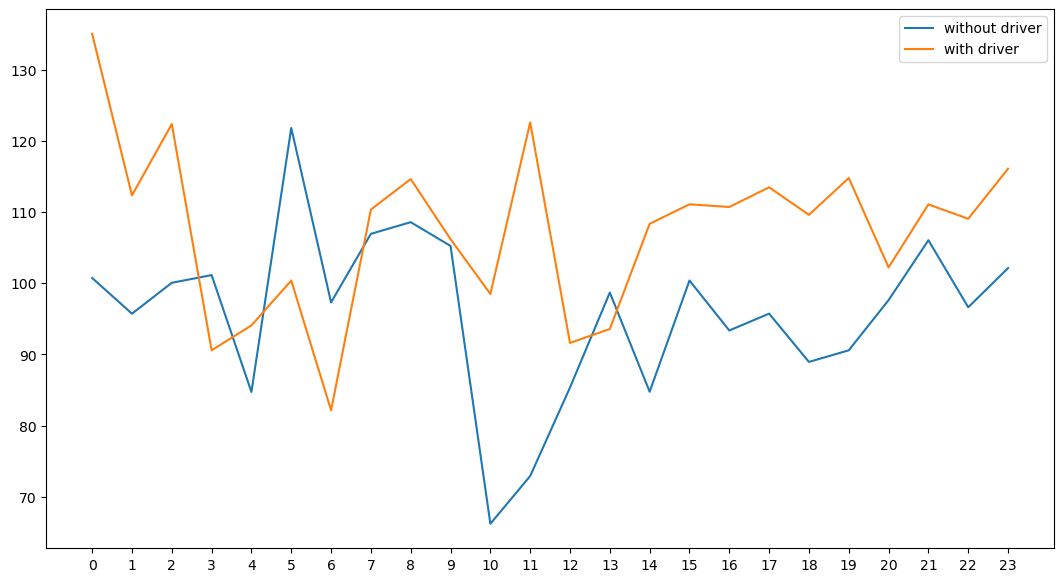

In [239]:
plt.figure(figsize=(13,7))
y1=hours[hours['is_driver_assigned_key']=='yes']['cancellations_time_in_seconds']
y2=hours[hours['is_driver_assigned_key']=='no']['cancellations_time_in_seconds']
x=hours['order_datetime'].unique()
plt.plot(x, y2, label = "without driver")
plt.plot(x, y1, label = "with driver")
plt.xticks(range(0,24))
plt.legend()
plt.show()

### Task 4. Plot the distribution of average ETA by hours. How can this plot be explained?

In [240]:
df_task4=df_order.groupby(df_order.order_datetime.dt.hour)['m_order_eta'].mean().reset_index()

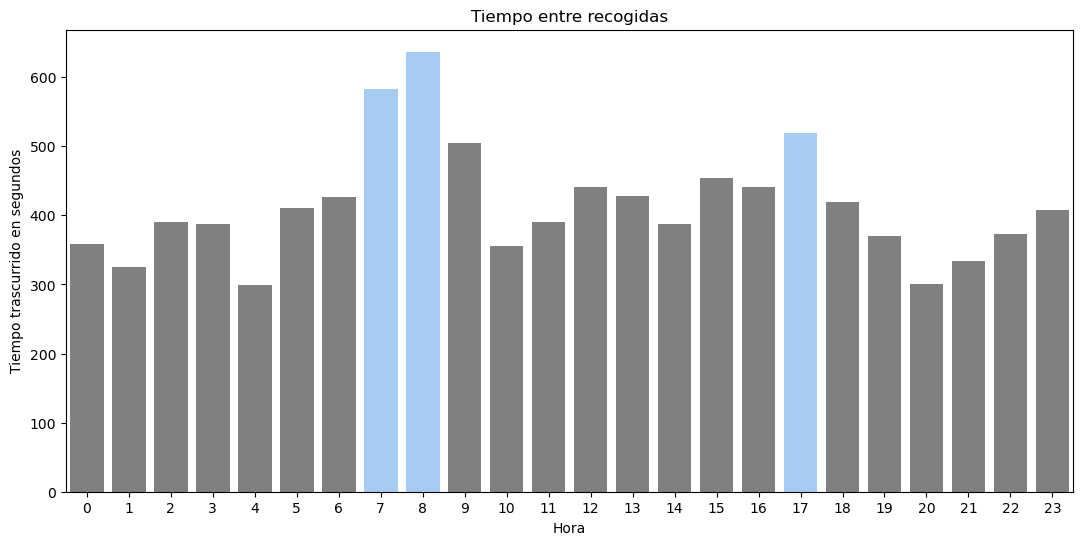

In [241]:
blue= '#99ccff'
custom_palette = [blue if val < 4 else 'gray' for val in df_task4['m_order_eta'].rank(method='first', ascending=False)]
plt.figure(figsize=(13, 6))
sns.barplot(x=df_task4['order_datetime'], y=df_task4['m_order_eta'], palette=custom_palette)
plt.title('Tiempo entre recogidas')
plt.xlabel('Hora')
plt.ylabel('Tiempo trascurrido en segundos')
plt.show()

### Task 5 BONUS. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

To obtain the number of hexagons with resolution 8 containing 80% of the total, we must:
- Obtain the id of each hexagon according to longitude and latitude.
- Count the number in each hexagon.
- Add the values and cut when we have 80% of the total.
- Obtain geojson features to use it in the Folium map.
- Finally, to apply different colors to the hexagons, use folium's style_function and change the intensity depending on the count.


In [242]:
df_order["hex_id"] = df_order.apply(func=lambda row: h3.geo_to_h3(lat=row["origin_latitude"], lng=row["origin_longitude"],resolution=8), axis=1)

In [243]:
df_map = df_order.groupby('hex_id')["order_gk"].count()


In [244]:
df_map=df_map.reset_index()
df_map=df_map.rename(columns={"order_gk": "count"})


In [245]:
df_map = df_map.sort_values("count",ascending=False) 
total = df_map["count"].sum()

In [246]:
df_map["cum_sum"] = df_map["count"].cumsum()
df_map["cum_porc"] = 100 * df_map["cum_sum"] / total


In [247]:
df_map=df_map[df_map["cum_porc"] <= 80]

In [248]:
df_map

,hex_id,count,cum_sum,cum_porc
97,88195d2b1dfffff,1497,1497,13.969765
96,88195d2b1bfffff,870,2367,22.088466
93,88195d2b15fffff,774,3141,29.311310
91,88195d2b11fffff,707,3848,35.908921
95,88195d2b19fffff,667,4515,42.133259
20,88195d284dfffff,653,5168,48.226950
63,88195d2a27fffff,414,5582,52.090332
89,88195d2b0bfffff,372,5954,55.561777
62,88195d2a25fffff,362,6316,58.939903
92,88195d2b13fffff,346,6662,62.168720


In [249]:
import json
import geojson
def to_geojson(row):    

    geometry = {"type": "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]}
    
    result = geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"count":row['count']})

    return result
                                                                                                                                                
geojsons = df_map.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))


In [250]:
print(geojsons[0])

{"geometry": {"coordinates": [[[-0.96742, 51.462334], [-0.974152, 51.461086], [-0.975317, 51.456585], [-0.969751, 51.453332], [-0.963019, 51.45458], [-0.961853, 51.459081], [-0.96742, 51.462334]]], "type": "Polygon"}, "id": "88195d2b1dfffff", "properties": {"count": 1497}, "type": "Feature"}


In [308]:
m = folium.Map(location=[df_order['origin_latitude'].mean(),df_order['origin_longitude'].mean()],zoom_start=13)

In [309]:
import matplotlib
# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="cividis")
max_count = df_map["count"].max()
min_count = df_map["count"].min()

In [310]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
 "fillColor": matplotlib.colors.to_hex(colormap((f["properties"]["count"]-min_count)/(max_count - min_count))),
'opacity':1,
"fillOpacity":0.6
}).add_to(m)

In [311]:
m